# Quantum Maze Solver

In [12]:
from maze_oracle import MazeOracle, MazeCircuitInfo, QuantumMazeCircuit, QuantumMazeSolver, Path
import sys
sys.path.insert(1, '../')
from utils import Helpers as hp
from maze_generator import BFSSolver, Graph, PrimGenerator


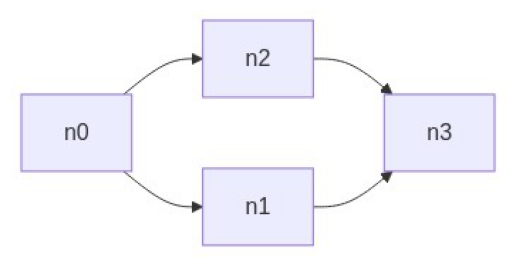

In [13]:
# from maze_generator import BFSSolver, Graph, PrimGenerator
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
]
graph = Graph.from_edges(edges, 0, 3, bidirectional=False)
graph.show()


In [14]:
quantum_solver = QuantumMazeSolver()
qc = QuantumMazeCircuit(graph, turn_back_check=True)
# qc.decompose(reps=2).draw('mpl')

[0 -> 1 -> 3] : 1728
[0 -> 2 -> 3] : 1682
[3 -> 2 -> 1] : 39
[0] : 38
[0 -> 1] : 37
[3 -> 2] : 37
[3 -> 1] : 37
[1 -> 3 -> 2] : 37
[1 -> 0 -> 3] : 36
[3] : 36
[1] : 36
[0 -> 1] : 35
[1 -> 0 -> 2] : 35
[1] : 35
[0] : 35
[2 -> 3 -> 1] : 35
[2] : 34
[0 -> 3 -> 1] : 34
[0] : 34
[3 -> 2 -> 1 -> 0] : 34
[3 -> 1] : 34
[2 -> 1] : 34
[1 -> 2] : 34
[1 -> 2 -> 0] : 34
[2 -> 3] : 33
[3 -> 0] : 33
[0] : 33
[2 -> 0 -> 1] : 33
[3 -> 0] : 33
[3] : 33
[1 -> 2 -> 3] : 33
[2 -> 1 -> 3] : 33
[3 -> 1] : 33
[3] : 33
[2 -> 0 -> 1 -> 3] : 33
[2 -> 0] : 32
[2 -> 1 -> 0] : 32
[1 -> 0] : 32
[1] : 32
[0 -> 3] : 32
[3 -> 0] : 32
[2 -> 0] : 31
[2 -> 0] : 31
[1 -> 0] : 31
[0 -> 1] : 31
[1 -> 0] : 30
[0 -> 2 -> 3] : 30
[3] : 30
[1 -> 2] : 30
[2 -> 1 -> 3] : 30
[2 -> 1 -> 0] : 30
[0 -> 1 -> 3] : 30
[1 -> 3 -> 2] : 30
[0] : 30
[0 -> 3 -> 1] : 30
[3 -> 1 -> 2] : 30
[0 -> 2] : 30
[0] : 30
[1 -> 2 -> 0] : 30
[3] : 30
[0 -> 3 -> 1 -> 2] : 30
[2 -> 1] : 30
[3 -> 0 -> 2] : 29
[1 -> 0 -> 3] : 29
[2] : 29
[1 -> 3] : 29
[2 -> 0

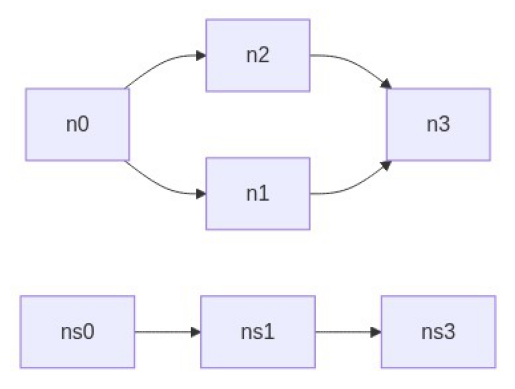

In [15]:
result = quantum_solver.run(qc, shots=10000)
from collections import Counter
ordered_solution_with_frequency = sorted(Counter(result).items(), key=lambda x: -x[1])
[print(k.remove_cycles(), ':', v) for k, v in ordered_solution_with_frequency]
most_frequent_solution_path = ordered_solution_with_frequency[0][0].remove_cycles()
graph.show(most_frequent_solution_path)

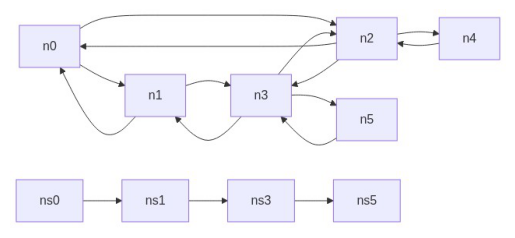

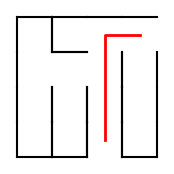

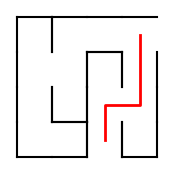

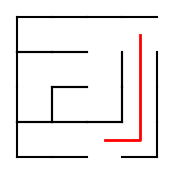

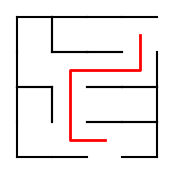

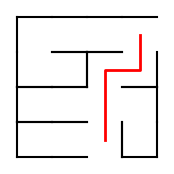

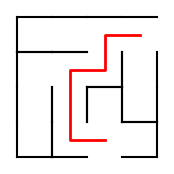

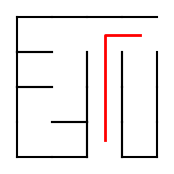

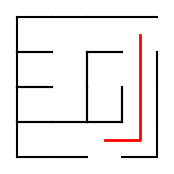

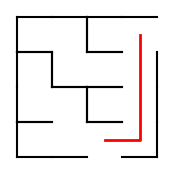

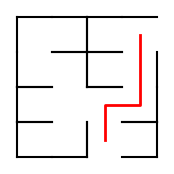

In [16]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
    (2, 4),
    (3, 5),
]
maze_generator = PrimGenerator()
solver = BFSSolver()
graph = Graph.from_edges(edges, 0, 5, bidirectional=True)
graph.show(solver.solve_graph(graph, 0, 5))
for i in range(10):
    maze = maze_generator.generate_maze(4, 4, (3,0), (2,3))
    path = solver.solve_maze(maze)
    maze.show(path)
